In [48]:
%%javascript
utils.load_extension("collapsible_headings/main")
utils.load_extension("hide_input/main")
utils.load_extension("autosavetime/main")
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension("code_prettify/code_prettify")
utils.load_extension("scroll_down/main")
utils.load_extension("jupyter-js-widgets/extension")

<IPython.core.display.Javascript object>

In [49]:

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder

plt.style.use("seaborn")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import mean_squared_error

from nnet import ReadDataset, Net,ResNet
import time
from loss_functions import interval_score_loss

from pytorch_tabnet.tab_model import TabNetClassifier
from gauss_rank_scaler import GaussRankScaler
tic = time.time()
from models.lgbm import (compute_metrics, preprocess)

from tools.metrics import (
    get_avg_volumes,
)
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [50]:

def plot_feature_importance(
    columnas, model_features, columns_ploted=10, model_name="Catboost"
):
    """
    This method is yet non-tested
    
    This function receives a set of columns feeded to a model, and the importance of each of feature.
    Returns a graphical visualization
    
    Call it fot catboost pipe example:
    plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,pipe_best_estimator.named_steps['cb'].get_feature_importance(),20)
    
    Call it for lasso pipe example:
    plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,np.array(pipe_best_estimator.named_steps['clf'].coef_.squeeze()),20)
    """

    feature_importance = pd.Series(index=columnas, data=np.abs(model_features))
    n_selected_features = (feature_importance > 0).sum()
    print(
        "{0:d} features, reduction of {1:2.2f}%".format(
            n_selected_features,
            (1 - n_selected_features / len(feature_importance)) * 100,
        )
    )
    plt.figure()
    feature_importance.sort_values().tail(columns_ploted).plot(
        kind="bar", figsize=(18, 6)
    )
    plt.title("Feature Importance for {}".format(model_name))
    plt.show()



In [51]:

def my_metric(pred, lower, upper):

    metric_pair = compute_metrics(
        preds=pred,
        lower=lower,
        upper=upper,
        y=val_y_raw,
        offset=val_offset,
        X=val_x_orig,
        avg_volumes=avg_volumes,
    )
    return metric_pair[0],metric_pair[1]


def postprocess_submission(submission_df, solve_submission_issues=True):

    join_on = ["country", "brand", "month_num"]
    keep = join_on + ["volume"]

    df_vol = pd.read_csv("../data/gx_volume.csv").loc[:, keep]

    both_ds = submission_df.merge(
        df_vol,
        on=join_on,
        how="left",
    )

    both_ds.loc[both_ds["volume"].notnull(), "prediction"] = both_ds[both_ds["volume"].notnull()]["volume"].values
    both_ds.loc[both_ds["volume"].notnull(), "pred_95_high"] = both_ds[both_ds["volume"].notnull()]["volume"].values + 0.01
    both_ds.loc[both_ds["volume"].notnull(), "pred_95_low"] = both_ds[both_ds["volume"].notnull()]["volume"].values - 0.01

    final_cols = join_on + ["pred_95_low", "prediction", "pred_95_high"]

    final_df =  both_ds.loc[:, final_cols]

    if solve_submission_issues:

        if (final_df.pred_95_low > final_df.pred_95_high).any():
            raise("Stop please, upper < lower")

        cond_lower_mean = final_df.pred_95_low > final_df.prediction
        if cond_lower_mean.any():
            print("Solving lower > mean")
            final_df.loc[cond_lower_mean, "prediction"] = \
                final_df.loc[cond_lower_mean, "pred_95_low"] + 0.01

        cond_upper_mean = final_df.prediction > final_df.pred_95_high
        if cond_upper_mean.any():
            print("Solving upper < mean")
            final_df.loc[cond_upper_mean, "prediction"] = \
                final_df.loc[cond_upper_mean, "pred_95_high"] - 0.01


    return final_df



In [52]:
file_name = "linear_base"
offset_name = "last_before_3_after_0"
full_df = pd.read_csv("../data/gx_merged_lags_months.csv")
    # volume_features = pd.read_csv("data/volume_features.csv")
submission_df = pd.read_csv("../data/submission_template.csv")
train_tuples = pd.read_csv("../data/train_split.csv")
valid_tuples = pd.read_csv("../data/valid_split.csv")

 
# full_df = full_df.merge(volume_features, on=["country", "brand"])


full_df["volume_offset"] = (full_df["volume"] - full_df[offset_name]) / full_df[offset_name]
full_df = preprocess(full_df)

test_df = full_df[full_df.test == 1].copy().reset_index(drop=True)

real_full = full_df.copy()

#full_df = full_df[full_df.test == 0]

train_df = full_df.merge(train_tuples, how="inner").reset_index(drop=True)
val_df = full_df.merge(valid_tuples, how="inner").reset_index(drop=True)

    # TODO: no need for calculation every time
avg_volumes = get_avg_volumes()

to_drop = ["volume", "volume_offset",'test','A','country_mean_before_24_after_0']
categorical_cols = [
        "country", "brand", "therapeutic_area", "presentation", "month_name",
        "month_country", "month_presentation", "month_area",
        "month_country_num", "month_presentation_num", "month_area_num",
        "month_month_num"
    ]

    # Prep data
train_x = train_df.drop(columns=to_drop)
train_y = train_df.volume_offset
train_offset = train_df[offset_name]



full_x = full_df.drop(columns=to_drop)
full_y = full_df.volume_offset
full_offset = full_df[offset_name]

real_full_x = real_full.drop(columns=to_drop)


val_x = val_df.drop(columns=to_drop)
val_x_orig = val_x
val_y = val_df.volume_offset
val_y_raw = val_df.volume
val_offset = val_df[offset_name]

test_x = test_df.drop(columns=to_drop)
test_offset = test_df[offset_name]

In [70]:
df = full_df._get_numeric_data()
df = df.drop(
    columns=[
        "volume_offset",
        "volume",
        "mean_before_Inf_after_0",
        "median_before_24_after_0",
        "brand_median_before_Inf_after_0",
        "median_before_Inf_after_0",
        "country_mean_before_Inf_after_0",
        "brand_mean_before_Inf_after_0",
        "mean_before_3_after_0",
        "median_before_12_after_0",
        "mean_before_24_after_0",
        "brand_mean_before_3_after_0",
        "country_mean_before_3_after_0",
        "brand_median_before_12_after_0",
        "brand_mean_before_24_after_0",
        "median_before_3_after_0",
        "mean_before_12_after_0",
        "brand_mean_before_12_after_0",
        "brand_median_before_24_after_0",
        "brand_median_before_3_after_0",
        "B",
        "D",
        "country_mean_before_24_after_0",
        "brand_last_before_Inf_after_0",
        "country_mean_before_12_after_0",
        "brand_last_before_24_after_0",
        "num_generics",
        "brand_last_before_3_after_0",
        "brand_last_before_12_after_0",
        "last_before_3_after_0",
        "last_before_24_after_0",
        "C",
    ]
)

In [71]:
df['random'] = np.random.rand(df.shape[0])

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='test'),df.test)

In [73]:
cb = CatBoostClassifier(iterations=100,verbose=0)
cb.fit(X_train,y_train)


14 features, reduction of 0.00%


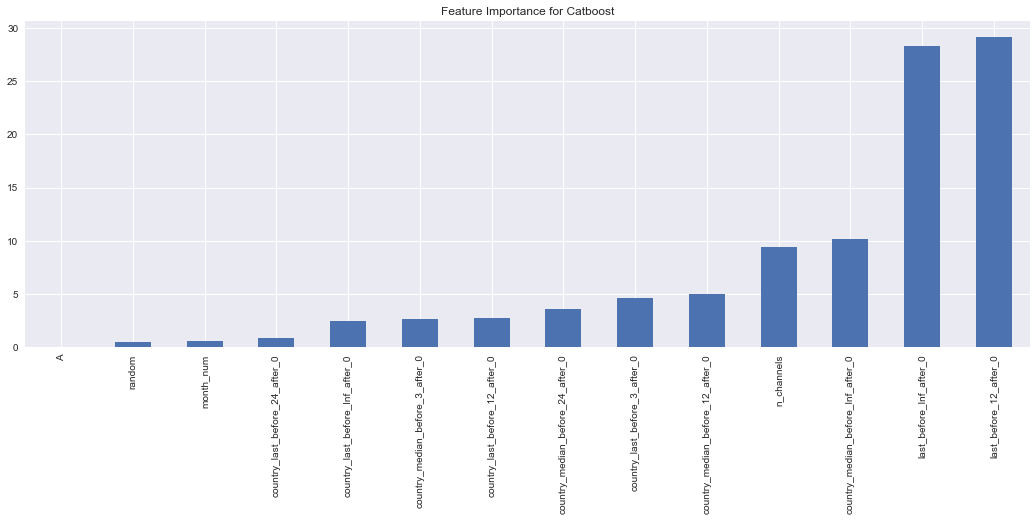

In [74]:
plot_feature_importance(X_train.columns,cb.get_feature_importance(),50)

In [75]:
roc_auc_score(y_test,cb.predict(X_test))

0.6792335820020001

In [67]:
d = [X_train.columns,cb.get_feature_importance()]

d = pd.DataFrame(d).T

d.columns = ['feat','impo']

#d.sort_values('impo',ascending=False).feat.to_list()
d.sort_values('impo',ascending=False).head(10)

,feat,impo
14,country_mean_before_12_after_0,17.5883
8,brand_last_before_24_after_0,12.2969
1,num_generics,9.87668
10,brand_last_before_3_after_0,9.46799
9,brand_last_before_12_after_0,8.58935
7,last_before_3_after_0,7.29981
4,last_before_24_after_0,7.11302
2,C,6.39018
5,last_before_12_after_0,4.32803
11,country_last_before_24_after_0,3.07172


In [68]:
d.sort_values('impo',ascending=False).feat.to_list()

['country_mean_before_12_after_0',
 'brand_last_before_24_after_0',
 'num_generics',
 'brand_last_before_3_after_0',
 'brand_last_before_12_after_0',
 'last_before_3_after_0',
 'last_before_24_after_0',
 'C',
 'last_before_12_after_0',
 'country_last_before_24_after_0',
 'last_before_Inf_after_0',
 'n_channels',
 'country_median_before_Inf_after_0',
 'country_median_before_24_after_0',
 'country_last_before_Inf_after_0',
 'country_last_before_3_after_0',
 'country_last_before_12_after_0',
 'country_median_before_12_after_0',
 'month_num',
 'random',
 'country_median_before_3_after_0',
 'A']

In [18]:
train = df[df['test']==0]
test = df[df['test']==1]

In [57]:
df.columns

Index(['month_num', 'test', 'num_generics', 'B', 'D', 'C', 'A',
       'last_before_24_after_0', 'mean_before_24_after_0',
       'median_before_24_after_0', 'last_before_12_after_0',
       'mean_before_12_after_0', 'median_before_12_after_0',
       'last_before_Inf_after_0', 'mean_before_Inf_after_0',
       'median_before_Inf_after_0', 'last_before_3_after_0',
       'mean_before_3_after_0', 'median_before_3_after_0',
       'brand_last_before_24_after_0', 'brand_mean_before_24_after_0',
       'brand_median_before_24_after_0', 'brand_last_before_12_after_0',
       'brand_mean_before_12_after_0', 'brand_median_before_12_after_0',
       'brand_last_before_Inf_after_0', 'brand_mean_before_Inf_after_0',
       'brand_median_before_Inf_after_0', 'brand_last_before_3_after_0',
       'brand_mean_before_3_after_0', 'brand_median_before_3_after_0',
       'country_last_before_24_after_0', 'country_mean_before_24_after_0',
       'country_median_before_24_after_0', 'country_last_before_1

<AxesSubplot:>

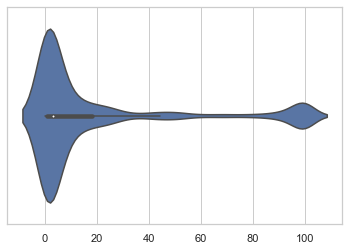

In [49]:
sns.violinplot(x=train.B.values)



<AxesSubplot:>

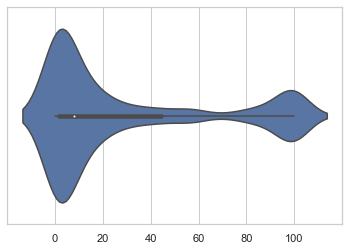

In [48]:
sns.violinplot(x=test.B.values)

<AxesSubplot:>

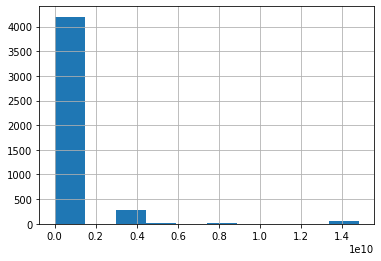

In [37]:
test.brand_last_before_Inf_after_0.hist()

In [87]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dt = DecisionTreeClassifier()
dt.fit(X_train['brand_mean_before_Inf_after_0'].values.reshape(-1, 1),y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [88]:
roc_auc_score(y_test,dt.predict(X_test['brand_mean_before_Inf_after_0'].values.reshape(-1, 1)))

0.8655823855830713

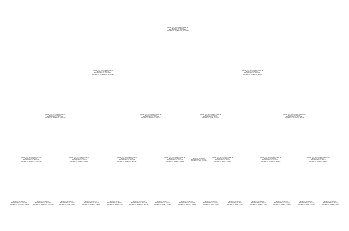

In [86]:
plt.figure()
plot_tree(dt);
plt.savefig('tree.svg',format='svg')
plt.show()